# Group Exercise CLV - Group 6
## Margin Modeling


Import Packages

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor    


## Import modeling data created in the Data Prep pipeline. Change path in below cell

In [2]:
import pickle
with open('combined_df.pkl', 'rb') as file:
    combined_df = pickle.load(file)

## Printing variable stats:

In [3]:
print(" summary stats on combined data ") 
"""print(combined_df.describe(include='all').transpose())"""
# describe only the numeric variables:
print(combined_df.describe(include = [np.number]).transpose())

 summary stats on combined data 
                           count      mean       std  min  25%  50%  75%  max
emailable               239356.0  0.515011  0.499776  0.0  0.0  1.0  1.0  1.0
solicit_ph_ind          239356.0  0.892415  0.309856  0.0  1.0  1.0  1.0  1.0
solicit_email_ind       239356.0  0.964079  0.186095  0.0  1.0  1.0  1.0  1.0
fixd_incm_flg           239356.0  0.092494  0.289723  0.0  0.0  0.0  0.0  1.0
scheduled_purchase_flg  239356.0  0.260039  0.438657  0.0  0.0  0.0  1.0  1.0
...                          ...       ...       ...  ...  ...  ...  ...  ...
Region_Other            239356.0  0.006643  0.081233  0.0  0.0  0.0  0.0  1.0
Region_South            239356.0  0.270580  0.444260  0.0  0.0  0.0  1.0  1.0
Region_Southeast        239356.0  0.161082  0.367608  0.0  0.0  0.0  0.0  1.0
Region_Southwest        239356.0  0.037267  0.189415  0.0  0.0  0.0  0.0  1.0
Region_West             239356.0  0.159177  0.365842  0.0  0.0  0.0  0.0  1.0

[126 rows x 8 columns]


## Basic exploratory analysis:

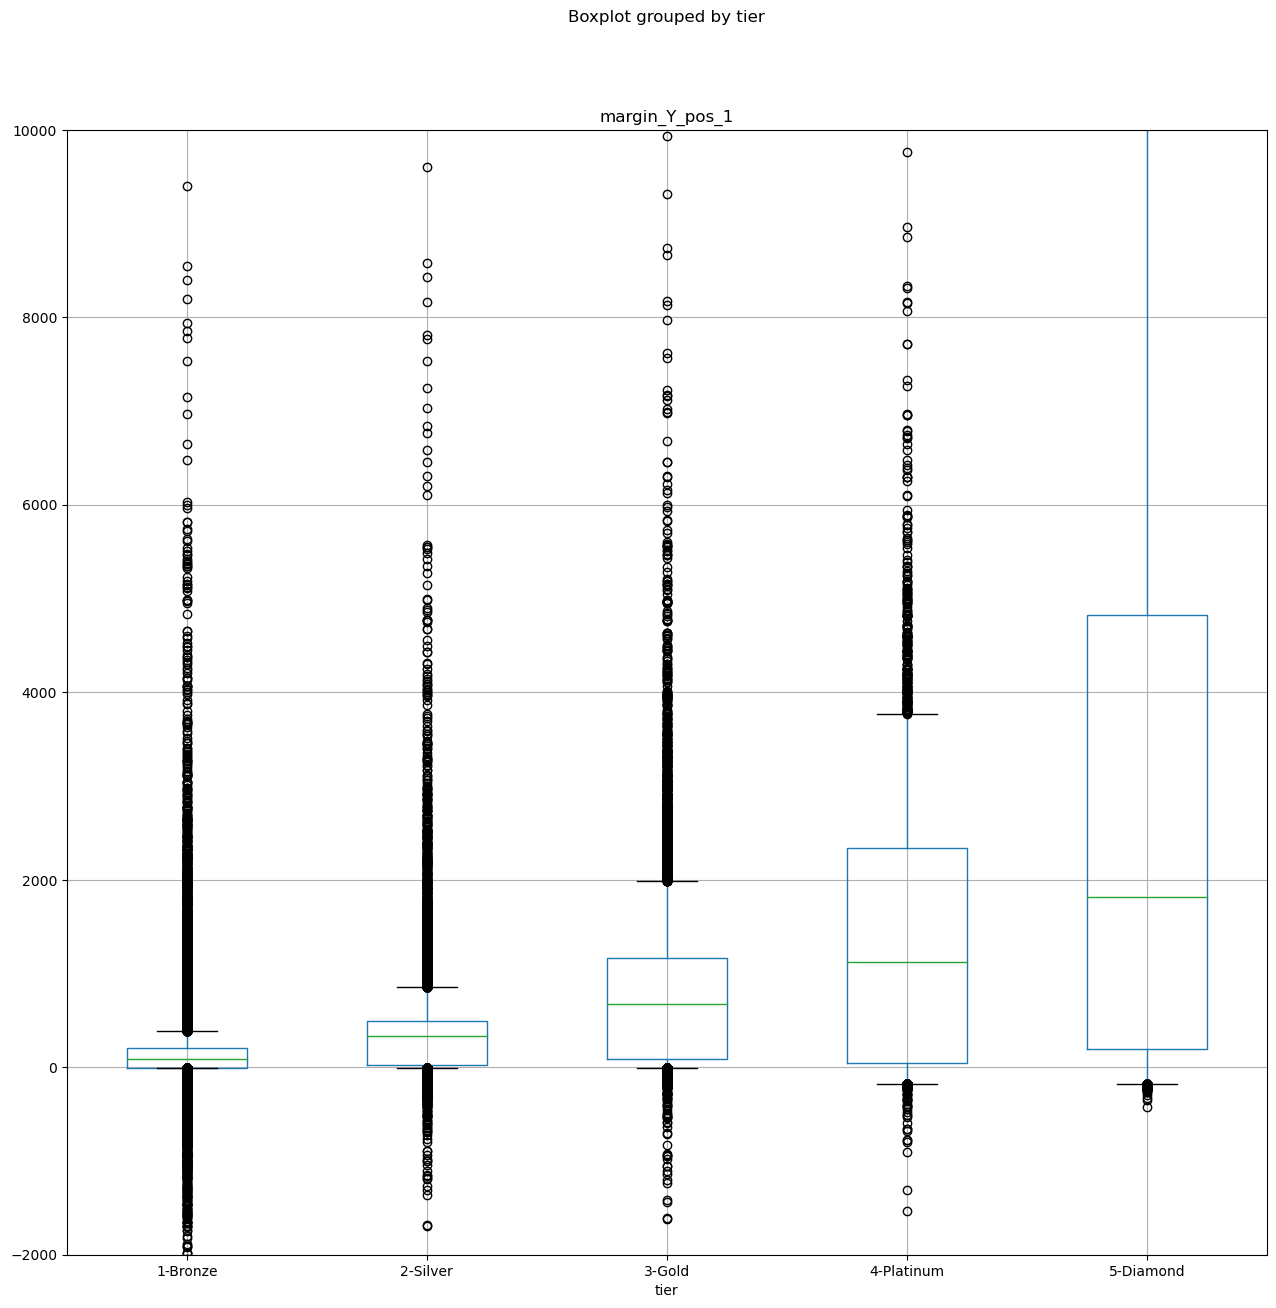

In [4]:
""" A boxplot to investigate the distribution of target variable by a categorical variable """

axes = combined_df.boxplot(column='margin_Y_pos_1', by='tier',figsize=(15,15),
                   whis=[5,95])
# given the extreme values/range for future margin, limiting the range of the y-axis:
axes.set(ylim=(-2000, 10000))
    
plt.show()

## Dropping variables we don't want included in modeling:

In [5]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST','tier','tier_prev','demog_ownrent','Region'
                              ],axis=1)

x_train_df.shape

(239356, 127)

This step was not performed for churn modeling.
We are going to eliminate the records associated with the "churners".


Because of our approach to calculating future value, we want to predict the expect future margin *given* that the customer remains a customer.

In [6]:
""" first we keep the churners, to score them later """
x_churners_df = x_train_df.query('churn_year_plus1_ind==1')
""" then we strip our the churners from the data to be used for training and testing """
x_train_df = x_train_df.query('churn_year_plus1_ind==0')

x_train_df.shape
# we will score the churners later, but don't want them used for model training

(176267, 127)

In [7]:
# Changing any boolean columns into int datatypes to prevent errors
boolean_columns = list(x_train_df.dtypes[x_train_df.dtypes == 'bool'].index)
x_train_df[boolean_columns] = x_train_df[boolean_columns].astype('int')

Partitioning data into Training and Test sets, creating X vs Y sets, and creating dataframes with just account IDs to be used to rejoin data later.


**Note:** for margin modeling, we have a different target variable than we did for churn.

In [8]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]
churners_acct_IDs_df = x_churners_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['log_margin_Y_pos_1']]
y_test_df  = x_test_df[['log_margin_Y_pos_1']]
y_churners_df  = x_churners_df[['log_margin_Y_pos_1']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for churn modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_churners_df = x_churners_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                                   ],axis=1)

x_train_df.shape

(123386, 123)

## Using the SelectKBest and f_regression to select K parameters with highest f-values.
We'll use this as a preliminary non-machine-learning approach.

In [9]:
""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)
y_test_array=np.ravel(y_test_df)

# this line can be used to suppress any warnings caused by missing values:
"""np.seterr(divide='ignore', invalid='ignore')"""

model1_selects = SelectKBest(f_regression, k=20).fit(x_train_df, y_train_array)

x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]
""" note: we are not reducing the columns in the held-out churners dataframe, because this is not our final model """

x_train_selected_df.shape

(123386, 20)

Introducing variable reduction that addresses multicolinearity:

In [10]:
# function to calculate VIF for all independent variables and drop variables with VIF > 10
thresh=10

X = x_train_selected_df

dropped=True

while dropped==True:
    cols = X.columns
    variables = np.arange(X.shape[1])
    
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))

    # Drop variables with VIF values greater than 10    
    if max(vif) > thresh: 
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True
        
        print('Remaining Shape:')
        print(X.shape)
    else:
        dropped=False
    X = X.iloc[:, variables]

x_train_selected_df = X

c:\Users\ruthv\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


dropping 'margin_Y_neg_1' at index: 6
Remaining Shape:
(123386, 20)
dropping 'log_margin_3yr_avg' at index: 12
Remaining Shape:
(123386, 19)
dropping 'log_margin_Y_neg_2' at index: 10
Remaining Shape:
(123386, 18)
dropping 'log_margin_Y_neg_3' at index: 10
Remaining Shape:
(123386, 17)
dropping 'log_purch_amt_life' at index: 3
Remaining Shape:
(123386, 16)
dropping 'log_purch_amt_36mo' at index: 2
Remaining Shape:
(123386, 15)
dropping 'log_margin_Y_neg_1' at index: 7
Remaining Shape:
(123386, 14)
dropping 'margin_3yr_avg' at index: 6
Remaining Shape:
(123386, 13)
dropping 'log_purch_cnt_life' at index: 3
Remaining Shape:
(123386, 12)


In [11]:
""" reducing the test set to have the same columns as the training set """
""" note: we are not reducing the columns in the held-out churners dataframe, because this is not our final model """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]

print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['mail_cnt_36mo', 'call_out_mo_36mo', 'log_purch_avg_36mo',
       'margin_Y_neg_2', 'margin_Y_neg_3', 'tier_1-Bronze', 'tier_5-Diamond',
       'tier_prev_3-Gold', 'tier_prev_4-Platinum', 'tier_prev_5-Diamond',
       'tier_prev_xxx'],
      dtype='object')


(52881, 11)

## Using the statsmodels package to see "friendlier" looking Regression output:

 
OLS model with selected variables
 
                            OLS Regression Results                            
Dep. Variable:     log_margin_Y_pos_1   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                 1.318e+04
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:07:20   Log-Likelihood:             4.2761e+05
No. Observations:              123386   AIC:                        -8.552e+05
Df Residuals:                  123374   BIC:                        -8.551e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

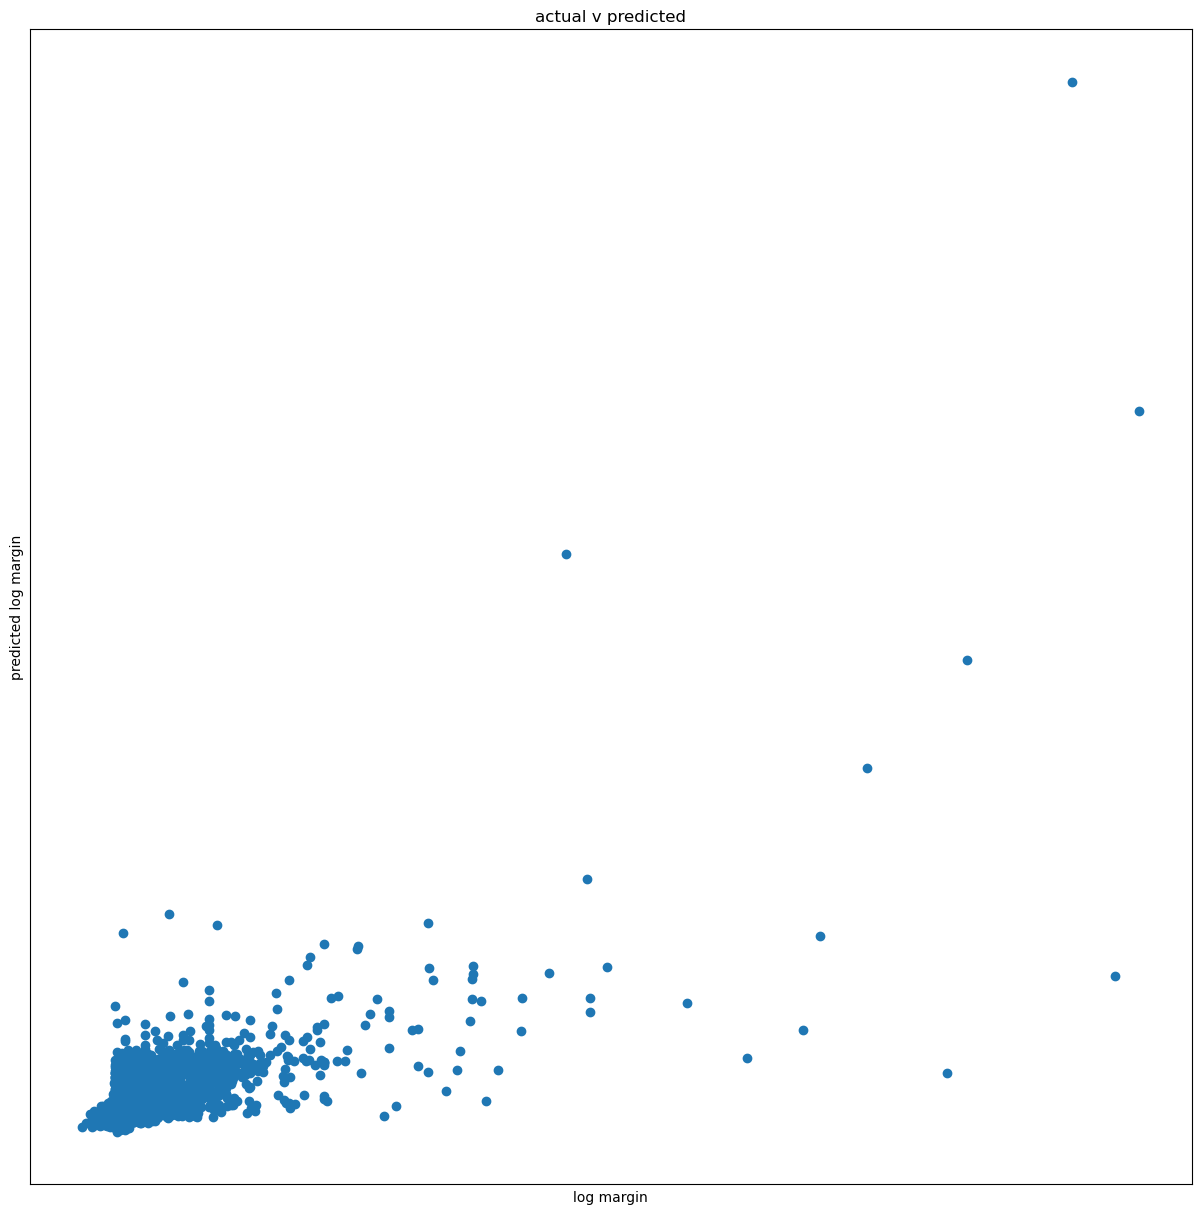

In [12]:
""" for the statsmodels, need to add a constant to fit intercept """
""" the add_constant function won't add a constant if there's already a variable with variance=0 """
"""     unless the has_constant option is added """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" warning:  the OLS here is case-sensitive """
model = sm.OLS(y_train_df, x_train_selected_df)
result = model.fit()
print(" ") 
print("OLS model with selected variables")
print(" ") 
print(result.summary())

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train:", mean_squared_error(y_train_array, predict_train))
print("MSE test:", mean_squared_error(y_test_array, predict_test))

plt.figure(figsize=(15,15))
plt.scatter(y_train_array, predict_train)
plt.xlabel("log margin")
plt.ylabel("predicted log margin")
plt.title("actual v predicted")
plt.xticks([])
plt.yticks([])
print(" ") 
plt.show()

## Now to try a more advanced Machine Learning algorithm to see if we can get a better model.
**Note:** with steps below, significant variables are selected based on GB model, not using the more simplified f-test approach above.

Make function to evaluate fitted models

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 4, 6],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'loss': ['squared_error']
}

# Create the GradientBoostingRegressor model
model_h = GradientBoostingRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_h, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(x_train_df, y_train_array)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters:", best_params)
print("Best score:", best_score)


KeyboardInterrupt: 

In [ ]:


""" Gradient Boosting """
params = {'n_estimators': 70, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01, 'loss': 'squared_error'}
model7 = GradientBoostingRegressor(**params)

""" switch the order of X and Y for the fit to work with GradientBoosting """
""" also, note that we are starting with the full training data, and not the selected variables from above """
result = model7.fit(x_train_df, y_train_array)

""" returns mean accuracy"""
accuracy = model7.score(x_test_df, y_test_df)
print("GB overall accuracy, for model with all variables:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model7.predict(x_train_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(model7.predict(x_test_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train, for model with all variables:", mean_squared_error(y_train_array, predict_train))
print("MSE test, for model with all variables:", mean_squared_error(y_test_array, predict_test))

# Plot feature importance
feature_importance = result.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance, for model with all variables')
plt.show()

""" plotting MSE with each iteration for the model with all variables """

test_MSE  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_MSE = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model7.staged_predict(x_test_df)):
    test_MSE[i] = mean_squared_error(y_test_array, y_pred)

for i, y_pred in enumerate(model7.staged_predict(x_train_df)):
    train_MSE[i] = mean_squared_error(y_train_array, y_pred)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('MSE by iteration, for the model with all variables')
plt.plot(np.arange(params['n_estimators']) + 1, train_MSE, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_MSE, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

""" select only impactful features """
""" note:  decrease/increase this threshold (a relative number between 0 and 100) to select more/less features """
selected_features = (feature_importance > 10)

""" creating a dataframe of independent variables, from the training (and test) data """
"""     having only those independent variables selected above """

x_train_selected_df = x_train_df[x_train_df.columns[selected_features]]
x_test_selected_df = x_test_df[x_test_df.columns[selected_features]]

""" we are also reducing columns in churners data, as this is our final model """
"""     and any data we want to score needs to have the correct columns """
x_churners_selected_df = x_churners_df[x_churners_df.columns[selected_features]]

""" refitting the model using a subset of features """
""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model7.fit(x_train_selected_df, y_train_array)
""" returns mean accuracy"""
accuracy = model7.score(x_test_selected_df, y_test_df)
print("GB overall accuracy, for model with only selected features:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model7.predict(x_train_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_test = pd.DataFrame(np.copy(model7.predict(x_test_selected_df)), columns=["P_log_margin_Y_pos_1"])
predict_churners = pd.DataFrame(np.copy(model7.predict(x_churners_selected_df)), columns=["P_log_margin_Y_pos_1"])

print(" ") 
print("MSE train, for model with only selected features:", mean_squared_error(y_train_array, predict_train))
print("MSE test, for model with only selected features:", mean_squared_error(y_test_array, predict_test))

plt.figure(figsize=(15,15))
plt.scatter(y_train_array, predict_train)
plt.xlabel("log margin")
plt.ylabel("predicted log margin")
plt.title("actual v predicted, for model using only selected variables")
plt.xticks([])
plt.yticks([])
print(" ") 
plt.show()

""" plotting MSE with each iteration """

test_MSE  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_MSE = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model7.staged_predict(x_test_selected_df)):
    test_MSE[i] = mean_squared_error(y_test_array, y_pred)

for i, y_pred in enumerate(model7.staged_predict(x_train_selected_df)):
    train_MSE[i] = mean_squared_error(y_train_array, y_pred)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('MSE by iteration, for model using only selected features')
plt.plot(np.arange(params['n_estimators']) + 1, train_MSE, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_MSE, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

Feature Importances

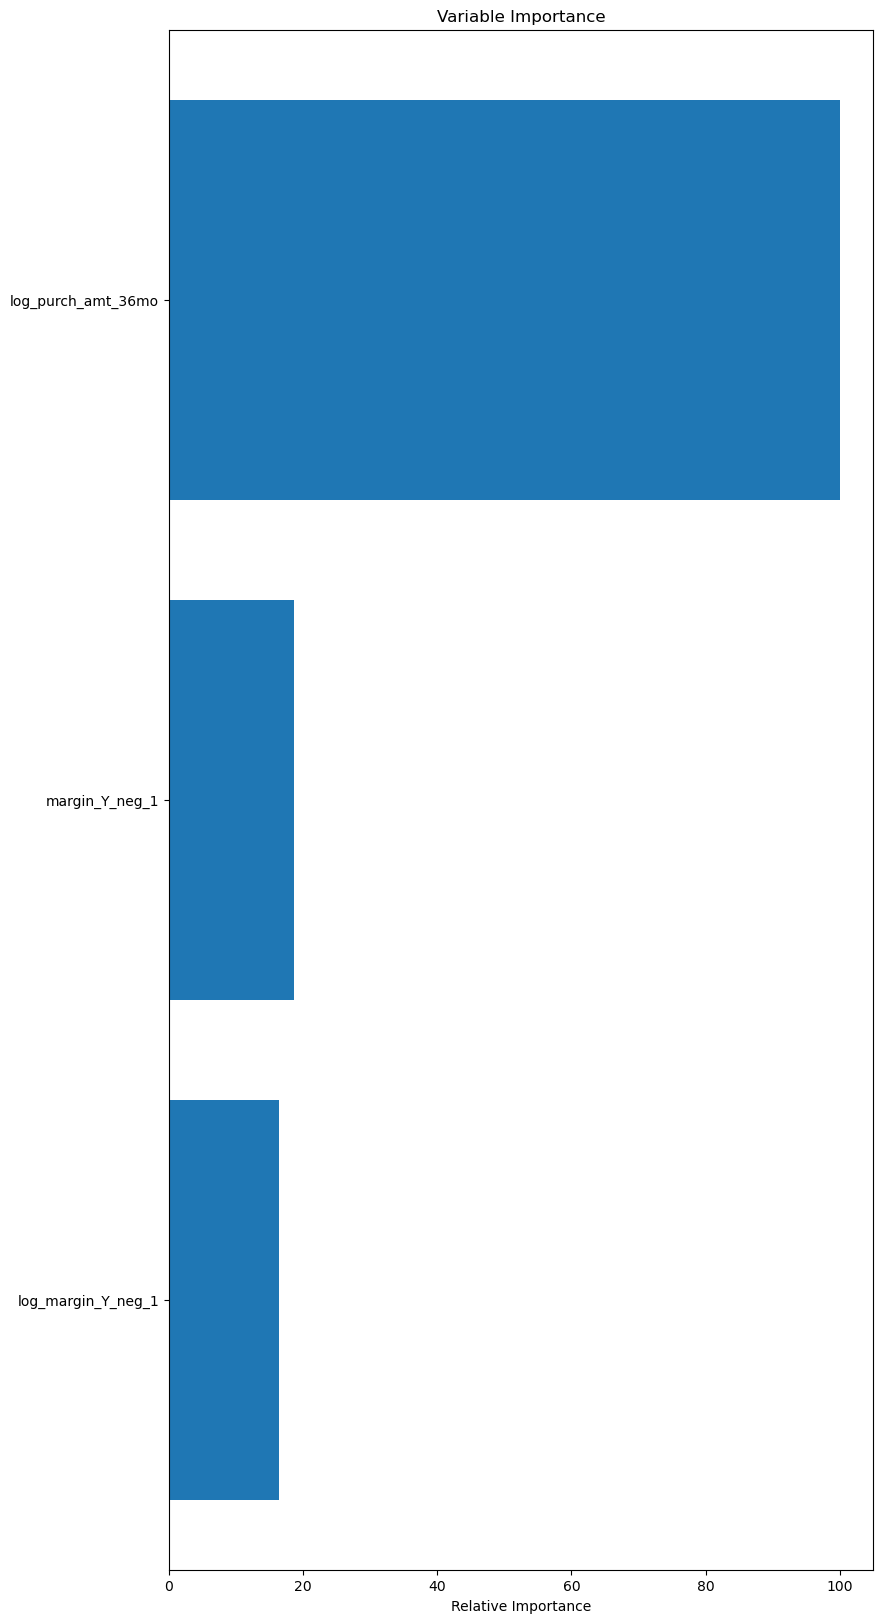

In [14]:
feature_importance = model7.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [15]:
""" append together train and test predicted values, keeping only acct ID and predicted values """
""" also predicting values for the held-out churners and appending those, so we have all rows """

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)
y_churners_df = y_churners_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

churners_accounts = churners_acct_IDs_df.reset_index(drop=True)
pred_v_actual_churners = y_churners_df.join(predict_churners)
pred_v_actual_churners = pred_v_actual_churners.join(churners_accounts)

""" appending test to train, and calling it train """
pred_v_actual_train = pd.concat([pred_v_actual_train, pred_v_actual_test], ignore_index=True)

""" appending churners to train, and calling it train """
pred_v_actual_train = pd.concat([pred_v_actual_train, pred_v_actual_churners], ignore_index=True)

""" dropping the actuals and keeping just the predicted values """
pred_v_actual_train = pred_v_actual_train.drop(['log_margin_Y_pos_1'
                             ],axis=1)

""" and then save predicted values by acct ID to csv """

## Change path in below code
pred_v_actual_train.to_csv('margin_scores.csv',index=False)
pred_v_actual_train.shape

(239356, 2)